Flask是Django之外用Python实现的另一优秀Web框架。相对于功能全面的Django，Flask以自由、灵活著称。在开发一些小应用的时候，使用Django会有“杀鸡用牛刀”的赶脚，而使用Flask就非常合适。本文将使用Flask开发一个微博用户画像的生成器，最后效果如下：
![](./static/images/weibo_personas.gif)

**开发步骤如下：**

1. 抓取微博用户数据；
2. 分析数据，生成用户画像；
3. 网站实现，美化界面。

### 一、微博抓取 ###

这里使用移动端的微博(m.weibo.cn),以为例。本教程使用chrome浏览器进行调试。

1. 在“发现”中搜索“古力娜扎”，点击进入她的主页；
2. 开始分析请求报文, 右击打开调试窗口，选择调试窗口的"网络(network)"标签；
3. 选择"Preserve Log",刷新页面；
4. 分析各条请求过程可以发现博文的数据是从https://m.weibo.cn/api/container/getIndex?XXX 类似的地址中得到的。其主要参数为type(固定值)、value(博主ID)、containerid(标识，请求中返回)、page(页码)

![](./static/images/weibo.gif)

下面开始实现爬取博文的代码。

In [8]:
# 导入相关库
import requests
from time import sleep

In [27]:
# 定义获取博主信息的函数
# 参数uid为博主的id

def get_user_info(uid):
    # 发送请求
    result = requests.get('https://m.weibo.cn/api/container/getIndex?type=uid&value={}'
                          .format(uid))
    json_data = result.json()  # 获取繁华信息中json内容
    userinfo = {
        'name': json_data['userInfo']['screen_name'],                    # 获取用户头像
        'description': json_data['userInfo']['description'],             # 获取用户描述
        'follow_count': json_data['userInfo']['follow_count'],           # 获取关注数
        'followers_count': json_data['userInfo']['followers_count'],     # 获取粉丝数
        'profile_image_url': json_data['userInfo']['profile_image_url'], # 获取头像
        'verified_reason': json_data['userInfo']['verified_reason'],     # 认证信息
        'containerid': json_data['tabsInfo']['tabs'][1]['containerid']   # 此字段在获取博文中需要
    }
    
    # 获取性别，微博中m表示男性，f表示女性
    if json_data['userInfo']['gender'] == 'm':
        gender = '男'
    elif json_data['userInfo']['gender'] == 'f':
        gender = '女'
    else:
        gender = '未知'
    userinfo['gender'] = gender
    return userinfo

In [28]:
# 获取古力娜扎信息
userinfo = get_user_info('1350995007')

In [29]:
# 信息如下
userinfo

{'containerid': '1076031350995007',
 'description': '工作请联系：nazhagongzuo@163.com',
 'follow_count': 529,
 'followers_count': 12042995,
 'name': '我是娜扎',
 'profile_image_url': 'https://tvax2.sinaimg.cn/crop.0.0.1242.1242.180/50868c3fly8fevjzsp2j4j20yi0yi419.jpg',
 'verified_reason': '演员，代表作《择天记》'}

In [33]:
# 循环获取所有博文

def get_all_post(uid, containerid):
    # 从第一页开始
    page = 0 
    # 这个用来存放博文列表
    posts = []
    while True:
        # 请求博文列表
        result = requests.get('https://m.weibo.cn/api/container/getIndex?type=uid&value={}&containerid={}&page={}'
                              .format(uid, containerid, page))
        json_data = result.json()
        
        # 当博文获取完毕，退出循环
        if not json_data['cards']:
            break
            
        # 循环将新的博文加入列表
        for i in json_data['cards']:
            posts.append(i['mblog']['text'])
            
        # 停顿半秒，避免被反爬虫
        sleep(0.5)
        
        # 跳转至下一页
        page += 1
        
    # 返回所有博文
    return posts

In [34]:
posts = get_all_post('1350995007', '1076031350995007')

In [35]:
# 查看博文条数
len(posts)

1279

In [36]:
# 显示前3个
posts[:3]

['哈哈同款buzi不是都送你们了么<span class="url-icon"><img src="//h5.sinaimg.cn/m/emoticon/icon/default/d_feijie-c1d5b12e04.png" style="width:1em;height:1em;" alt="[费解]"></span>一起抗黑🌚//<a href=\'https://m.weibo.cn/n/楊祐寧YOYANG\'>@楊祐寧YOYANG</a>:回复<a href=\'https://m.weibo.cn/n/江疏影\'>@江疏影</a>:我後面是妳？？？？妳咋那黑啊👼🏿？就叫妳多跟古力娜buzi 學學吧<a href=\'https://m.weibo.cn/n/我是娜扎\'>@我是娜扎</a>//<a href=\'https://m.weibo.cn/n/江疏影\'>@江疏影</a>:有考虑过后面人的感受吗',
 '<a class=\'k\' href=\'https://m.weibo.cn/k/择天记?from=feed\'>#择天记#</a> 谁说容儿暴力？<span class="url-icon"><img src="//h5.sinaimg.cn/m/emoticon/icon/default/d_wabishi-f5765407f7.png" style="width:1em;height:1em;" alt="[挖鼻]"></span>走你～⚡ \u200b\u200b\u200b',
 '旅行学了点新技能<span class="url-icon"><img src="//h5.sinaimg.cn/m/emoticon/icon/default/d_xixi-ce63ce2629.png" style="width:1em;height:1em;" alt="[嘻嘻]"></span> 不用问了～最后一张我也没看懂<span class="url-icon"><img src="//h5.sinaimg.cn/m/emoticon/icon/default/d_heixian-4cbb6a297e.png" style="width:1em;height:1em;" alt="[黑线]"></span><a href=\'http

至此，用户的数据已准备就绪，接下来开始生成用户画像。

### 二、生成用户画像 ###

** 1.提取关键词 **

这里从博文列表中提取出关键字，分析出博主的发表的热词

In [95]:
import jieba.analyse
from html2text import html2text

content = '\n'.join([html2text(i) for i in posts])

# 这里使用jieba的textrank提取出1000个关键词及其比重
result = jieba.analyse.textrank(content, topK=1000, withWeight=True)

# 生成关键词比重字典
keywords = dict()
for i in result:
    keywords[i[0]] = i[1]

** 2.生成词云图 **

In [130]:
from PIL import Image, ImageSequence
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

# 初始化图片
image = Image.open('./static/images/personas.png')
graph = np.array(image)

# 生成云图，这里需要注意的是WordCloud默认不支持中文，所以这里需要加载中文黑体字库
wc = WordCloud(font_path='./fonts/simhei.ttf',
    background_color='white', max_words=300, mask=graph)
wc.generate_from_frequencies(keywords)
image_color = ImageColorGenerator(graph)

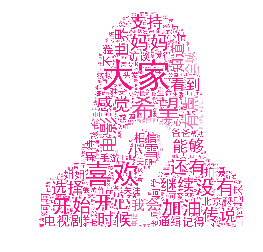

In [131]:
# 显示图片
plt.imshow(wc)
plt.imshow(wc.recolor(color_func=image_color))
plt.axis("off") # 关闭图像坐标系
plt.show()

# 三、实现Flask应用 ###

开发Flask不像Django那么复杂，小应用几个文件就可以完成。步骤如下：

**1. 安装**

使用pip安装flask，命令如下：

```bash
$ pip install flask
```

**2.实现应用逻辑**

简单来说，一个Flask应用就是一个Flask类，由route函数控制它的url请求。代码实现如下:

In [ ]:
# app.py


from flask import Flask
import requests
from PIL import Image, ImageSequence
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import jieba.analyse
from html2text import html2text
from time import sleep
from collections import OrderedDict
from flask import render_template, request

# 创建一个Flask应用
app = Flask(__name__)


##################################
# 微博相关函数 #

# 定义获取博主信息的函数
# 参数uid为博主的id

def get_user_info(uid):
    # 发送请求
    result = requests.get('https://m.weibo.cn/api/container/getIndex?type=uid&value={}'
                          .format(uid))
    json_data = result.json()  # 获取繁华信息中json内容
    # 获取性别，微博中m表示男性，f表示女性
    if json_data['userInfo']['gender'] == 'm':
        gender = '男'
    elif json_data['userInfo']['gender'] == 'f':
        gender = '女'
    else:
        gender = '未知'

    userinfo = OrderedDict()
    userinfo['昵称'] = json_data['userInfo']['screen_name']           # 获取用户头像
    userinfo['性别'] = gender                                         # 性别
    userinfo['关注数'] = json_data['userInfo']['follow_count']        # 获取关注数
    userinfo['粉丝数'] = json_data['userInfo']['followers_count']     # 获取粉丝数
    userinfo['认证信息'] = json_data['userInfo']['verified_reason']   # 获取粉丝数
    userinfo['描述'] = json_data['userInfo']['description']           # 获取粉丝数
    data = {
        'profile_image_url': json_data['userInfo']['profile_image_url'], # 获取头像
        'containerid': json_data['tabsInfo']['tabs'][1]['containerid'],  # 此字段在获取博文中需要
        'userinfo': '<br>'.join(['{}:{}'.format(k, v) for (k,v) in userinfo.items()])
    }

    return data


# 循环获取所有博文

def get_all_post(uid, containerid):
    # 从第一页开始
    page = 0
    # 这个用来存放博文列表
    posts = []
    while True:
        # 请求博文列表
        result = requests.get('https://m.weibo.cn/api/container/getIndex?type=uid&value={}&containerid={}&page={}'
                              .format(uid, containerid, page))
        json_data = result.json()

        # 当博文获取完毕，退出循环
        if not json_data['cards']:
            break

        # 循环将新的博文加入列表
        for i in json_data['cards']:
            posts.append(i['mblog']['text'])

        # 停顿半秒，避免被反爬虫
        sleep(0.5)

        # 跳转至下一页
        page += 1

    # 返回所有博文
    return posts


##############################
## 云图相关函数

# 生成云图
def generate_personas(uid, data_list):
    content = '<br>'.join([html2text(i) for i in data_list])

    # 这里使用jieba的textrank提取出1000个关键词及其比重
    result = jieba.analyse.textrank(content, topK=1000, withWeight=True)

    # 生成关键词比重字典
    keywords = dict()
    for i in result:
        keywords[i[0]] = i[1]

    # 初始化图片
    image = Image.open('./static/images/personas.png')
    graph = np.array(image)

    # 生成云图，这里需要注意的是WordCloud默认不支持中文，所以这里需要加载中文黑体字库
    wc = WordCloud(font_path='./static/fonts/simhei.ttf',
        background_color='white', max_words=300, mask=graph)
    wc.generate_from_frequencies(keywords)
    image_color = ImageColorGenerator(graph)
    plt.imshow(wc)
    plt.imshow(wc.recolor(color_func=image_color))
    plt.axis("off") # 关闭图像坐标系
    dest_img = './static/personas/{}.png'.format(uid)
    plt.savefig(dest_img)
    return dest_img


#######################################
# 定义路由
# 指定根路径请求的响应函数
@app.route('/', methods=['GET', 'POST'])
def index():
    # 初始化模版数据为空
    userinfo = {}
    # 如果是一个Post请求,并且有微博用户id,则获取微博数据并生成相应云图
    # request.method的值为请求方法
    # request.form既为提交的表单
    if request.method == 'POST' and request.form.get('uid'):
        uid = request.form.get('uid')
        userinfo = get_user_info(uid)
        posts = get_all_post(uid, userinfo['containerid'])
        dest_img = generate_personas(uid, posts)
        userinfo['personas'] = dest_img
    return render_template('index.html', **userinfo)


if __name__ == '__main__':
    app.run()

以上就是全部的代码，简单吧？当然，单文件结构只适合小的应用，随着功能和代码量的增加，还是需要把代码分离中不同的文件结构中以便开发和维护。最后，还差一个页面的模版文件。

**3.模版开发**

模版需要有一个输入的表单和用户信息展示，基于Jinja2模版引擎。熟悉Django模版的应该可以很快上手，流程也和Django类型，在项目根目录下建一个名为templates的文件夹并新建一个名为index.html的文件，代码如下：

```html
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <link rel="stylesheet" type="text/css" href="{{ url_for('static', filename='css/style.css') }}">
    <title>Flask之微博单用户画像生成器</title>
</head>
<body>
<!--提交微博id的表单-->
<div>
    <form action="/" method="post" id="search-form">
        <input type="text" name="uid" class="search" placeholder="微博用户ID">
        <input type="submit" class="submit" value="生成画像">
    </form>
</div>
<!--下面是用户的展示信息-->
<!--使用了模版的if语法,如果有才展示这块内容-->
{% if profile_image_url %}
<div style="text-align:center">
    <div>
        <img src="{{profile_image_url}}" alt="">
        <div id="userinfo" style="padding:10px;line-height:25px">
            {{ userinfo|safe }}
        </div>
    </div>
    <div>
        <img id="personas" src="{{ personas }}">
    </div>
</div>
{% endif %}
</body>
</html>
```

这样，应用实现完毕，项目结构如下：
```
$ tree .
weibo_personas
├── app.py
├── static
│   ├── css
│   │   └── style.css
│   ├── fonts
│   │   └── simhei.ttf
│   └── images
│       └── personas.png
└── templates
    └── index.html
```

进入项目文件夹，启动项目：

```
$ python app.py
* Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
```

然后浏览器打开http://127.0.0.1:5000 地址就可以看到本教程最上面的效果。

以上只是一个初步实现，还有很多需要完善的地方。比如，如果发布的博文比较多时，获取时间比较长，可以考虑加个缓存，存储已获取的用户，避免重复请求，前端也可以加个loading效果。本教程展示的只是单用户，后面也可以批量获取用户信息，生成一个群体的用户画像。

最后祝大家端午节快乐^_^